누락값 찾기, 이상값 식별, 변수 간 논리적 불일치, (선형회귀, k-nearest, isolation forest)

### 누락값 식별

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
c = pd.read_csv("data/covidtotalswithmissings.csv")

In [38]:
totvars = ['total_cases', 'total_deaths',
       'total_cases_pm', 'total_deaths_pm']
demovars = ['population', 'pop_density',
       'median_age', 'gdp_per_capita', 'hosp_beds']

In [12]:
c[demovars].isnull().sum(axis=1)

0      0
1      0
2      0
3      3
4      1
      ..
205    0
206    3
207    0
208    0
209    0
Length: 210, dtype: int64

In [ ]:
c[demovars].isnull().sum(axis=1).value_counts() #누락된 변수 체크 

0    156
1     24
2     12
3     10
4      8
Name: count, dtype: int64

In [18]:
c.loc[c[demovars].isnull().sum(axis=1) >= 3, ["location"] + demovars].head(5).T

,3,5,24,28,64
location,Andorra,Anguilla,Bonaire Sint Eustatius and Saba,British Virgin Islands,Faeroe Islands
population,77265.0,15002.0,26221.0,30237.0,48865.0
pop_density,163.755,NaN,NaN,207.973,35.308
median_age,NaN,NaN,NaN,NaN,NaN
gdp_per_capita,NaN,NaN,NaN,NaN,NaN
hosp_beds,NaN,NaN,NaN,NaN,NaN


In [21]:
c[totvars].isnull().sum(axis=0)

location           0
total_cases        0
total_deaths       0
total_cases_pm     1
total_deaths_pm    1
dtype: int64

In [22]:
c.loc[c[totvars].isnull().sum(axis=1) >= 1, ["location"]+totvars]

,location,location,total_cases,total_deaths,total_cases_pm,total_deaths_pm
87,Hong Kong,Hong Kong,0,0,NaN,NaN


### 이상값, 분포

In [ ]:
import statsmodels.api as sm
import scipy.stats as scistat

c.set_index('iso_code', inplace=True)
conly = c.loc[:,totvars]

In [41]:
conly.quantile(np.arange(0.0,1.1,0.1))

,total_cases,total_deaths,total_cases_pm,total_deaths_pm
0.0,0.0,0.0,0.0000,0.0000
0.1,22.9,0.0,17.9986,0.0000
0.2,105.2,2.0,56.2910,0.3752
0.3,302.0,6.7,115.4341,1.7183
0.4,762.0,12.0,213.9734,3.9566
0.5,1242.5,25.5,280.9285,6.1540
0.6,2514.6,54.6,543.9562,12.2452
0.7,6959.8,137.2,1071.2442,25.9459
0.8,16847.2,323.2,2206.2982,49.9658
0.9,46513.1,1616.9,3765.1363,138.9045


In [43]:
conly.skew()
conly.kurtosis()

total_cases        134.979577
total_deaths        95.737841
total_cases_pm      25.242790
total_deaths_pm     27.238232
dtype: float64

In [44]:
stat, p = scistat.shapiro(conly['total_cases'])
p

np.float64(3.753761827331286e-29)

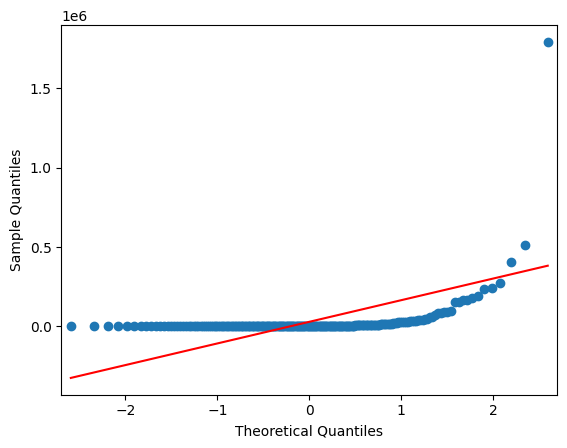

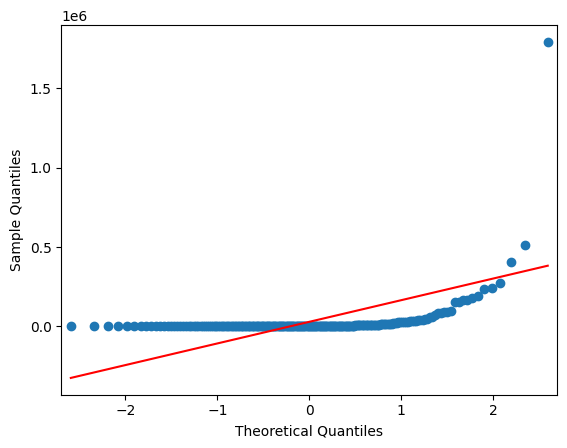

In [45]:
sm.qqplot(conly[['total_cases']].sort_values(['total_cases']), line='s')

In [48]:
# 값과 1,3사분위 값의 거리를 재어 1-3거리*1.5보다 크면 이상값
thirdq, firstq = conly.total_cases.quantile(0.75), conly.total_cases.quantile(0.25)
outlier_point = 1.5*(thirdq-firstq)
oh, ol = outlier_point+thirdq, firstq-outlier_point
print(ol,oh,sep="~")

-14736.125~25028.875


In [72]:
def getoutliers():
    dfout = pd.DataFrame(columns=c.columns, data=None)
    for col in conly.columns[:]:
        thirdq, firstq = conly[col].quantile(0.75), conly[col].quantile(0.25)
        outlier_point = 1.5*(thirdq-firstq)
        oh, ol = outlier_point+thirdq, firstq-outlier_point

        df = c.loc[(c[col]>oh)| (c[col]<ol)]
        df = df.assign(varname=col, threshlow = ol, threshhigh = oh)
        dfout = pd.concat([dfout,df])
    return dfout

In [74]:
outliers = getoutliers()
outliers.varname.value_counts()

/var/folders/8r/7lqlzhld40jfhd5w5cgxjcp00000gn/T/ipykernel_55312/378560486.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfout = pd.concat([dfout,df])


varname
total_deaths       36
total_cases        33
total_deaths_pm    28
total_cases_pm     17
Name: count, dtype: int64

In [76]:
outliers.loc[outliers.varname=='total_cases_pm', ['location','total_cases_pm']].sort_values(['total_cases_pm'], ascending=False)

,location,total_cases_pm
SMR,San Marino,19771.348
QAT,Qatar,19753.146
VAT,Vatican,14833.127
AND,Andorra,9888.048
BHR,Bahrain,6698.468
LUX,Luxembourg,6418.776
KWT,Kuwait,6332.420
SGP,Singapore,5962.727
USA,United States,5408.389
ISL,Iceland,5292.308


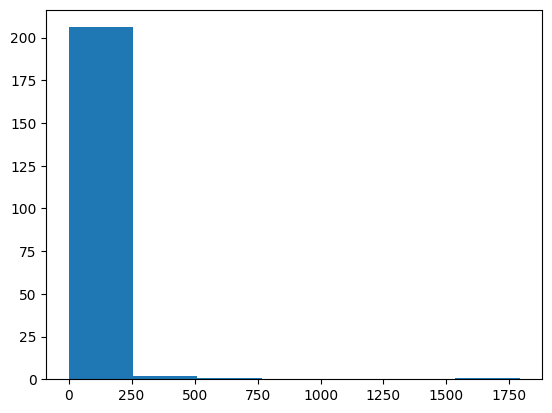

(array([ 3., 30., 41., 61., 44., 25.,  6.]),
 array([ 0.        ,  2.05683335,  4.1136667 ,  6.17050004,  8.22733339,
        10.28416674, 12.34100009, 14.39783343]),
 <BarContainer object of 7 artists>)

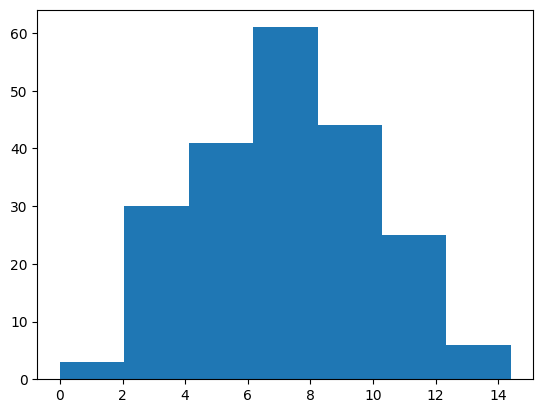

In [77]:
plt.hist(conly['total_cases']/1000,bins=7)
plt.show()
clog = conly.copy()
for col in conly.columns:
    clog[col] = np.log1p(clog[col])
plt.hist(clog['total_cases'], bins=7)


### subset

In [79]:
nls97 = pd.read_csv('data/nls97.csv')
nls97.set_index('personid',inplace=True)

In [83]:
nls97.loc[(nls97.wageincome > 0) & (nls97.weeksworked16 == 0), ['weeksworked16','wageincome']]

,weeksworked16,wageincome
personid,,
102625,0.0,1200.0
109403,0.0,5000.0
118704,0.0,25000.0
130701,0.0,12000.0
131151,0.0,65000.0
...,...,...
957344,0.0,90000.0
966697,0.0,65000.0
969334,0.0,5000.0


In [108]:
#4년제 대학에 등록한 적이 있다
nls97.filter(like='colenr').apply(lambda x: x.str[0:1] =='3').head(2).T
a = nls97.filter(like='colenr').apply(lambda x: x.str[0:1] =='3').any(axis=1)
nls97[a].loc[:,"colenrfeb13":"colenroct17"]

,colenrfeb13,colenroct13,colenrfeb14,colenroct14,colenrfeb15,colenroct15,colenrfeb16,colenroct16,colenrfeb17,colenroct17
personid,,,,,,,,,,
100061,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled
100292,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,NaN,NaN,NaN,NaN
100583,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled
100833,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled
101288,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,3. 4-year college,3. 4-year college,3. 4-year college,3. 4-year college,3. 4-year college
...,...,...,...,...,...,...,...,...,...,...
998556,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled
999031,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,NaN,NaN,NaN,NaN
999291,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled,1. Not enrolled


In [126]:
#대학원 등록 but 학사과정 x
cond = nls97.filter(like='colenr').apply(lambda x: (x.str[0:1] =='4')).any(axis=1) & ~(nls97.filter(like='colenr').apply(lambda x: (x.str[0:1] =='3'))).any(axis=1)

nobach = nls97.loc[cond, "colenrfeb97": "colenroct17"]
len(nobach)

#임금소득이 높은사람
highwages = nls97.loc[nls97.wageincome >= nls97.wageincome.mean()+(nls97.wageincome.std()*3), ['wageincome']]
highwages




,wageincome
personid,
131858,235884.0
133619,235884.0
151863,235884.0
164058,235884.0
164897,235884.0
...,...
964406,235884.0
966024,235884.0
976141,235884.0


In [129]:
#최근 근무 주 수 급격변화!
workchanges = nls97.loc[~nls97.loc[:,"weeksworked12":"weeksworked16"].mean(axis=1).between(nls97.weeksworked17*0.5, nls97.weeksworked17*2) & ~nls97.weeksworked17.isnull(),"weeksworked12":"weeksworked17"]
workchanges

,weeksworked12,weeksworked13,weeksworked14,weeksworked15,weeksworked16,weeksworked17
personid,,,,,,
100284,0.0,NaN,11.0,52.0,47.0,0.0
101526,0.0,0.0,0.0,0.0,0.0,45.0
101718,52.0,9.0,0.0,32.0,0.0,0.0
101724,52.0,52.0,52.0,17.0,0.0,17.0
102228,52.0,52.0,17.0,0.0,0.0,0.0
...,...,...,...,...,...,...
995842,24.0,0.0,0.0,2.0,53.0,52.0
997483,0.0,0.0,21.0,0.0,0.0,0.0
998321,0.0,24.0,52.0,52.0,48.0,7.0


In [132]:
ltgrade12 = nls97.loc[nls97.highestgradecompleted<12, ['highestgradecompleted','highestdegree']]
pd.crosstab(ltgrade12.highestgradecompleted, ltgrade12.highestdegree)

highestdegree,0. None,1. GED,2. High School
highestgradecompleted,,,
5.0,0,0,1
6.0,11,5,0
7.0,24,6,1
8.0,113,78,7
9.0,112,169,8
10.0,111,204,13
11.0,120,200,41


### K-nearest

In [ ]:
import pandas as pd
from pyod.models.knn import KNN
from sklearn.preprocessing import StandardScaler

covid = pd.read_csv("data/covidtotals.csv")
covid.set_index("iso_code",inplace=True)

In [2]:
covid.columns

Index(['lastdate', 'location', 'total_cases', 'total_deaths', 'total_cases_pm',
       'total_deaths_pm', 'population', 'pop_density', 'median_age',
       'gdp_per_capita', 'hosp_beds'],
      dtype='object')

In [3]:
standardizer = StandardScaler()
analysisvars = ['location','total_cases_pm','total_deaths_pm', 'pop_density', 'median_age','gdp_per_capita' ]
covidanal = covid.loc[:, analysisvars].dropna()
covidanalstand = standardizer.fit_transform(covidanal.iloc[:,1:])

In [4]:
clf = KNN(contamination=0.1)
clf.fit(covidanalstand)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [5]:
y_pred  = clf.labels_
y_scores = clf.decision_scores_

In [6]:
pred = pd.DataFrame(zip(y_pred,y_scores), columns=['outlier','scores'],index=covidanal.index)

In [7]:
pred.sample(10, random_state=2)

,outlier,scores
iso_code,,
BHR,1,2.842906
BRA,0,0.961794
UGA,0,0.236686
BGR,0,0.537156
CHN,0,0.469053
BGD,0,1.162860
GRD,0,0.388448
QAT,1,8.001605
PRT,0,1.236215


In [8]:
covidanal.join(pred).loc[pred.outlier==1, ['location','total_cases_pm','total_deaths_pm','scores']].sort_values(['scores'],ascending=False)

,location,total_cases_pm,total_deaths_pm,scores
iso_code,,,,
SGP,Singapore,5962.727,3.931,9.483549
QAT,Qatar,19753.146,13.190,8.001605
HKG,Hong Kong,0.000,0.000,7.771722
BEL,Belgium,5037.354,816.852,3.544827
BHR,Bahrain,6698.468,11.166,2.842906
LUX,Luxembourg,6418.776,175.726,2.442886
ESP,Spain,5120.952,580.197,2.176441
KWT,Kuwait,6332.420,49.642,2.127519
GBR,United Kingdom,4047.403,566.965,2.103458


Isolation Forest

In [9]:
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from mpl_toolkits.mplot3d import Axes3D


In [10]:
clf2 = IsolationForest(n_estimators=100, max_samples='auto', contamination= .1, max_features=1.0)
clf2.fit(covidanalstand)

IsolationForest(contamination=0.1)

In [11]:
covidanal['anomaly'] = clf2.predict(covidanalstand)
covidanal['scores'] = clf2.decision_function(covidanalstand)
covidanal.anomaly.value_counts()

anomaly
 1    157
-1     18
Name: count, dtype: int64

In [12]:
inlier, outlier = covidanal.loc[covidanal.anomaly==1], covidanal.loc[covidanal.anomaly==-1]

In [15]:
outlier[['location','total_cases_pm','total_deaths_pm','median_age','gdp_per_capita','scores']].sort_values(['scores']).head(10)

,location,total_cases_pm,total_deaths_pm,median_age,gdp_per_capita,scores
iso_code,,,,,,
QAT,Qatar,19753.146,13.190,31.9,116935.600,-0.220891
SGP,Singapore,5962.727,3.931,42.4,85535.383,-0.191330
HKG,Hong Kong,0.000,0.000,44.8,56054.920,-0.146023
BEL,Belgium,5037.354,816.852,41.8,42658.576,-0.131810
BHR,Bahrain,6698.468,11.166,32.4,43290.705,-0.094040
ITA,Italy,3853.985,552.663,47.9,35220.084,-0.081045
LUX,Luxembourg,6418.776,175.726,39.7,94277.965,-0.079465
ESP,Spain,5120.952,580.197,45.5,34272.360,-0.067463
IRL,Ireland,5060.962,334.562,38.7,67335.293,-0.047752


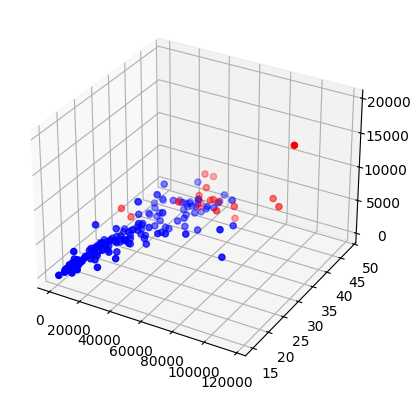

In [18]:
ax = plt.axes(projection = '3d')
ax.scatter3D(inlier.gdp_per_capita, inlier.median_age, inlier.total_cases_pm, label = "inliers",c ="blue")
ax.scatter3D(outlier.gdp_per_capita, outlier.median_age, outlier.total_cases_pm, label = "inliers",c ="red")
